В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 
Нам нужно построить модель, которая по входным данным предсказывала бы с максимальной точностью ключе-вой параметр. 
Основной параметр это delinq60plus. Остальные парамет-ры интуитивно понятны из таблиц.
# Цель

Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

# Задача
осуществить корректную загрузку данных
осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)

построить модель и оценить ее качество
при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели


# Высокая цель. Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы. 

Ожидаемый результат:
AUC на обучающей выборке: 0.865
AUC на контрольной выборке: 0.854
Рекомендую построить Confusion matrix что бы понять как ваша модель ошибаеться. 

ПС: В реальных задачах могут быть требования что бы мы например угадывали 99% плохих транзакций. Попробуйте поиграться с весами. ПСС - нейронные сети не дадут тут результат сильно лучше классических методов.




In [1]:

import pandas as pd
import numpy as np
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import catboost as cb

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

In [2]:

dft = pd.read_csv('MFOcredit.csv', encoding='cp1251', sep=';') 
con = sqlite3.connect('DB_SQL') 

dft.to_sql('MFOcredit',con,index=False,if_exists='replace')

def select(sql):
  return pd.read_sql(sql,con)

sql =  ''' SELect*FROM MFOcredit AS cr '''
df = select(sql)

In [3]:
# Формирование признака term
df['date_start']= pd.to_datetime(df['date_start'])
df['date_end']= pd.to_datetime(df['date_end'])
df["term"] = (df['date_end']-df['date_start']).dt.days


In [4]:
# Удаление не нужных столбцов
df = df.drop(columns=["date_start", "date_end", "id"])
# Преобразование категориальные значения в цисловые значения с помощью метода map в столбце delinq60plus
df['delinq60plus'] = df['delinq60plus'].map({'Да': 1, 'Нет': 0})

In [5]:
#Разбиение данных на тест и обучение
X = df.drop(["delinq60plus"], axis=1)
Y = df["delinq60plus"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [6]:
# разбиение данных на категориальные и числовые
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', "bool"]).columns

# формирование Pipeline предобработки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [7]:
# Использование ColumnTransformer для формирования препроцессинга предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#SGDClassifier

In [8]:
# формирование Pipeline
SGD_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier ())])

# формирование сетки гиперпараметров
param_grid_SGD = {'classifier__penalty': ['l1', 'l2'],
                  'classifier__loss' : ['hinge', 'log', 'modified_huber'],
                  'classifier__alpha' : [0.0001, 0.001]}
SGD_clf_grid = GridSearchCV(SGD_clf, param_grid_SGD, cv = 5, verbose = 0, n_jobs = -1)

# обучение и предсказание
SGD_clf_grid.fit(X_train, Y_train)
pred_SGD_clf = SGD_clf_grid.predict(X_test)
# print(  f1_score(y_test, pred_SGD_clf),
#         precision_score(y_test, pred_SGD_clf),
#         recall_score(y_test, pred_SGD_clf))
print(classification_report(Y_test, pred_SGD_clf))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77      5471
           1       0.61      0.28      0.38      3332

    accuracy                           0.66      8803
   macro avg       0.64      0.59      0.57      8803
weighted avg       0.65      0.66      0.62      8803



In [9]:
cm = confusion_matrix (Y_test, pred_SGD_clf)
cm

array([[4893,  578],
       [2412,  920]], dtype=int64)

Text(0, 0.5, 'Точность')

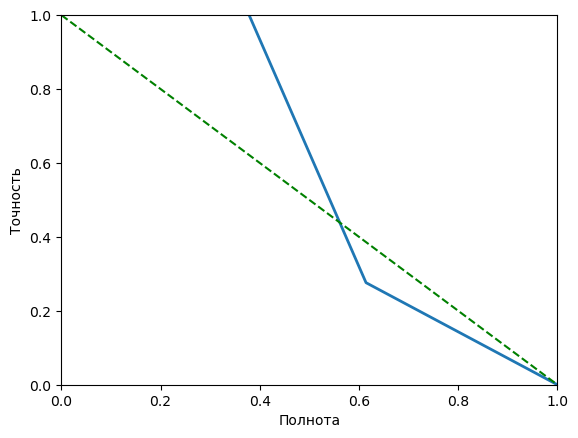

In [10]:
pre, rec, tr = precision_recall_curve(Y_test, pred_SGD_clf)
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')

#XGBoost

In [11]:

# формирование Pipeline
XGB_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier())])




# Создание параметров модели
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
        
}

# Создание сетки параметров для перебора
param_grid = {
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__n_estimators': [100, 500, 1000]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=XGB_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

# Поиск наилучших параметров
grid_search.fit(X_train, Y_train)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search.best_params_)

# Получение наилучшей модели
best_model = grid_search.best_estimator_

# Предсказание на тестовой выборке
pred_XGB_clf = best_model.predict(X_test)
print(classification_report(Y_test, pred_XGB_clf))

Наилучшие параметры: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 500}
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      5471
           1       0.60      0.37      0.46      3332

    accuracy                           0.67      8803
   macro avg       0.64      0.61      0.61      8803
weighted avg       0.65      0.67      0.65      8803



In [12]:
cm = confusion_matrix (Y_test, pred_XGB_clf)
cm

array([[4632,  839],
       [2090, 1242]], dtype=int64)

Text(0, 0.5, 'Точность')

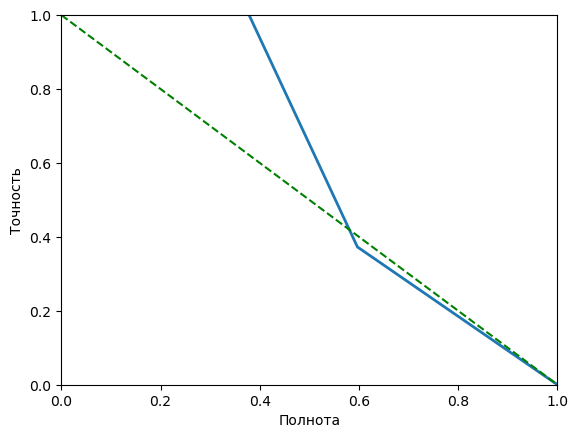

In [13]:
pre, rec, tr = precision_recall_curve(Y_test, pred_XGB_clf)
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')

# CatBoost

In [14]:



# Создание экземпляра Pipeline
# Append SGDClassifier  to the  preprocessor
CB_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', cb.CatBoostClassifier())])

    
# Определение сетки параметров для GridSearchCV
param_grid = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__depth': [3, 5, 7]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(CB_clf, param_grid, cv=5, scoring='accuracy')

# Обучение модели с использованием GridSearchCV
grid_search.fit(X_train, Y_train)

# Получение лучших параметров и оценки
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Предсказание на тестовой выборке
pred_CB_clf = grid_search.predict(X_test)







    
    

0:	learn: 0.6794496	total: 162ms	remaining: 2m 42s
1:	learn: 0.6686761	total: 170ms	remaining: 1m 24s
2:	learn: 0.6596826	total: 178ms	remaining: 59.1s
3:	learn: 0.6535164	total: 185ms	remaining: 46.2s
4:	learn: 0.6478820	total: 195ms	remaining: 38.8s
5:	learn: 0.6425340	total: 203ms	remaining: 33.6s
6:	learn: 0.6381413	total: 211ms	remaining: 30s
7:	learn: 0.6345728	total: 220ms	remaining: 27.2s
8:	learn: 0.6314214	total: 227ms	remaining: 24.9s
9:	learn: 0.6288250	total: 234ms	remaining: 23.2s
10:	learn: 0.6266649	total: 242ms	remaining: 21.8s
11:	learn: 0.6247783	total: 249ms	remaining: 20.5s
12:	learn: 0.6230736	total: 257ms	remaining: 19.5s
13:	learn: 0.6216956	total: 265ms	remaining: 18.6s
14:	learn: 0.6204582	total: 272ms	remaining: 17.9s
15:	learn: 0.6193114	total: 280ms	remaining: 17.2s
16:	learn: 0.6183480	total: 288ms	remaining: 16.7s
17:	learn: 0.6176440	total: 298ms	remaining: 16.3s
18:	learn: 0.6169863	total: 307ms	remaining: 15.8s
19:	learn: 0.6162449	total: 316ms	remaini

In [15]:
print(classification_report(Y_test, pred_CB_clf))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      5471
           1       0.60      0.37      0.46      3332

    accuracy                           0.67      8803
   macro avg       0.65      0.61      0.61      8803
weighted avg       0.66      0.67      0.65      8803



Text(0, 0.5, 'Точность')

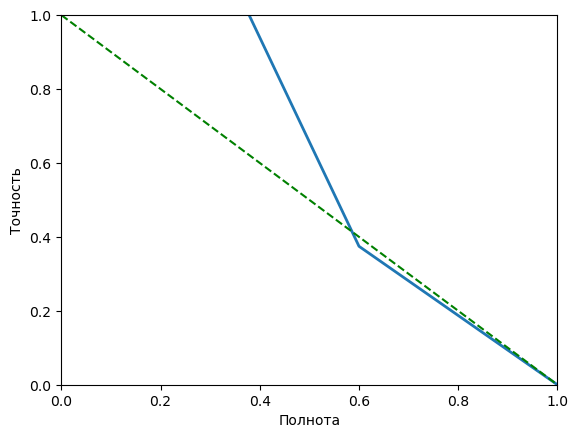

In [19]:
pre, rec, tr = precision_recall_curve(Y_test, pred_CB_clf)
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')